In [159]:
import numpy as np
import random
import progressbar
from IPython.display import clear_output
from pprint import pprint
from collections import deque
from matplotlib import pyplot as plt

# ML
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, initializers

In [160]:
class Environment:
    def __init__(self, endposition: tuple, nenemies: int):
        self.observation_space = ("x","y")
        self.action_space = ["up","down","left","right"]
        self.mapsize = (7,7)
        if endposition[0] >= self.mapsize[0] or endposition[1] >= self.mapsize[1]:
            raise ValueError(f"End position outside of map of size {self.mapsize}")
        self.endposition = endposition
        self.enemies = []
        self._build_enemies(nenemies)
        self.state = None
    
    def _build_enemies(self, nenemies: int):
        while len(self.enemies) < nenemies:
            x = np.random.randint(0, self.mapsize[0])
            y = np.random.randint(0, self.mapsize[1])
            if not (self.is_end(x,y)) and not (x,y) in self.enemies:
                self.enemies.append((x,y))
        
    def _build_state(self, x, y):
        return np.array([x,y], dtype=np.float32)
            
    def is_end(self, *args):
        if len(args)==1:
            # state
            state = args[0]
            return state == self.endposition
        elif len(args)==2:
            # x, y
            x = args[0]
            y = args[1]
            return (x,y) == self.endposition
        else:
            raise ValueError("[IsEnd] Invalid number of arguments passed")
    
    def is_enemy(self, *args):
        if len(args)==1:
            # state
            state = args[0]
            return (state[0], state[1]) in self.enemies
        elif len(args)==2:
            # x, y
            x = args[0]
            y = args[1]
            return (x,y) in self.enemies
        else:
            raise ValueError("[IsEnd] Invalid number of arguments passed")
    
    def showmap(self):
        fig, ax = plt.subplots(figsize=(10,10))
        plt.title("Environment")
        envmap = np.full(self.mapsize, -1)
        for enemy in self.enemies:
            envmap[enemy[0]][enemy[1]] = -100
        envmap[self.endposition[0]][self.endposition[1]] = 100
        plt.xlabel("x-coordinate")
        plt.ylabel("y-coorinate")
        ax.imshow(envmap)
        plt.show()
    
    def reset(self):
        self.state = [np.random.randint(0, self.mapsize[0]), np.random.randint(0, self.mapsize[1])]
        while self.is_end(self.state) or self.is_enemy(self.state):
            self.state = [np.random.randint(0, self.mapsize[0]), np.random.randint(0, self.mapsize[1])]
        return self._build_state(self.state[0], self.state[1])

    def move(self, x, y, action_index):
        newx = x
        newy = y
        if self.action_space[action_index] == 'up' and x > 0:
            newx -= 1
        elif self.action_space[action_index] == 'down' and x < self.mapsize[0] - 1:
            newx += 1
        elif self.action_space[action_index] == 'left' and y > 0:
            newy -= 1
        elif self.action_space[action_index] == 'right' and y < self.mapsize[1] - 1:
            newy += 1
        return newx, newy
            
    
    def step(self, actionindex):
        oldx, oldy = self.state
        x, y = self.move(oldx, oldy, actionindex)
        done = self.is_end(x,y)
        if done:
            reward = 200
        else:
            if self.is_enemy(x,y):
                reward = -200
            elif (oldx, oldy) == (x,y):
                # went out of map (did not move)
                reward = -100
            else:
                reward = -1
        self.state = (x,y)
        return self.state, reward, done, {}

In [161]:
class Agent:
    def __init__(self, env):
        self.env = env
        # Initialize attributes
        self._state_size = len(env.observation_space)
        self._action_size = len(env.action_space)
        #self._optimizer = optimizer
        
        self.memory = deque(maxlen=3000)
        
        # Initialize learning settings
        self.gamma = 0.99
        self.epsilon = 0.98  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.1
        
        # Build networks
        self.q_network = self._build_compile_model()
        self.target_network = self._build_compile_model()
        self.update_target_model()

    def store(self, state, action, reward, next_state, terminated):
        self.memory.append((state, action, reward, next_state, terminated))
    
    def _build_compile_model(self):
        model = models.Sequential()
        #model.add(layers.Embedding(self._state_size, 10, input_length=1))
        #model.add(layers.Reshape((10,)))
        model.add(layers.Dense(self.env.mapsize[0] * self.env.mapsize[1], input_dim=self._state_size, activation='relu',kernel_initializer=initializers.RandomNormal(stddev=0.01),
    bias_initializer=initializers.Zeros()))
        model.add(layers.Dense(50, activation='relu',kernel_initializer=initializers.RandomNormal(stddev=0.01),
    bias_initializer=initializers.Zeros()))
        model.add(layers.Dense(self._action_size, activation='linear',kernel_initializer=initializers.RandomNormal(stddev=0.01),
    bias_initializer=initializers.Zeros()))
        model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_network.set_weights(self.q_network.get_weights())
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self._action_size), "random"
        q_values = self.q_network.predict(state, verbose=0)
        maxq = np.argmax(q_values[0])
        return maxq, "best"
    
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        
        for state, action, reward, next_state, terminated in minibatch:
            target = self.q_network.predict(state, verbose=0)
            
            if terminated:
                target[0][action] = reward
            else:
                t = self.target_network.predict(next_state, verbose=0)[0]
                target[0][action] = reward + self.gamma * np.amax(t)
            
            self.q_network.fit(state, target, epochs=1, verbose=False)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
    
    def train(self, epochs: int, timesteps: int, batch_size: int):
        episode_rewards = []
        for e in range(0, epochs):
            # Reset the environment
            state = self.env.reset()
            state = np.reshape(state, [1, self._state_size])
            epochstartpos = state
            
            # Initialize variables
            reward = 0
            terminated = False

            #bar = progressbar.ProgressBar(maxval=timesteps/10, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
            #bar.start()
            episode_reward = 0
            for timestep in range(timesteps): 
                # Run Action
                action, choice = self.act(state)
                
                # Take action
                next_state, reward, done, info = self.env.step(action) 
                x,y = next_state
                next_state = np.reshape(next_state, [1, self._state_size])
                
                self.store(state, action, reward, next_state, terminated)
                print(f"Timestep {timestep+1}/{timesteps} of epoch {e+1}/{epochs} --> state= {epochstartpos}/{state}/{self.env.endposition} --> choice: {choice} --> reward= {reward} --> eps= {self.epsilon}", end='\r', flush=True)
                state = next_state
                
                #episode_reward += reward
                if done:
                    self.update_target_model()
                    break
                if len(self.memory) > batch_size:
                    self.replay(batch_size)
            episode_rewards.append(episode_reward)
        return episode_rewards
            
    
    def run(self, startpos):
        done = False
        self.env.reset()
        state = np.reshape(startpos, [1, self._state_size])
        shortestpath = []
        shortestpath.append(state)
        while not done:
            action = self.act(state)
            next_state, reward, done, info = self.env.step(action) 
            next_state = np.reshape(next_state, [1, self._state_size])
            shortestpath.append(next_state)
            print(next_state, end='\r', flush=True)
            state = next_state
        return shortestpath

In [162]:
env = Environment((6,6), 5)
a = Agent(env)

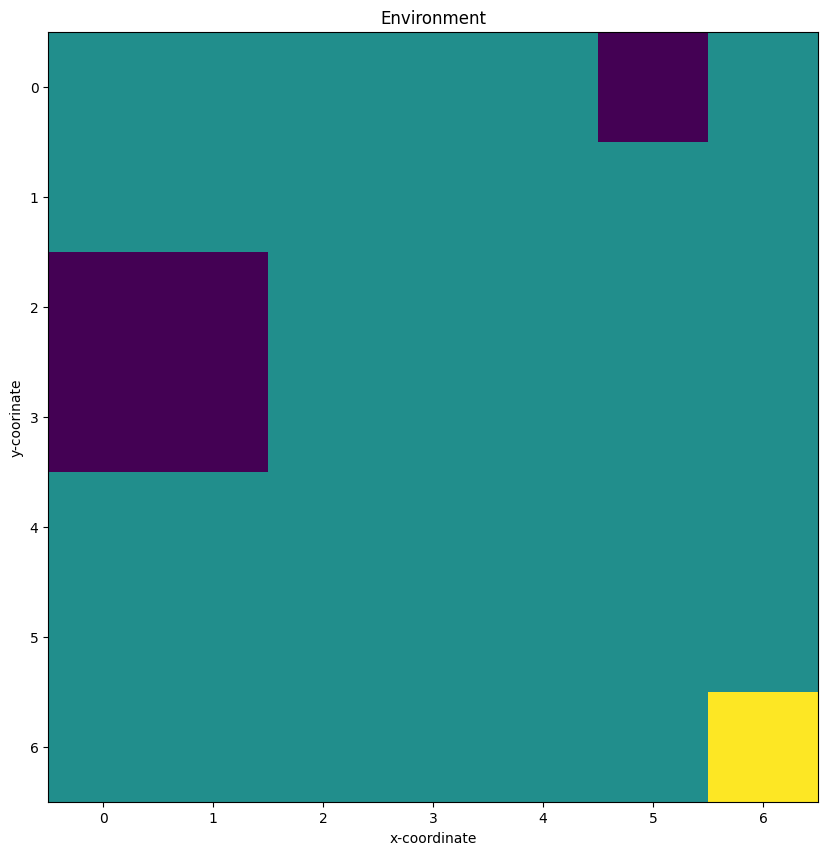

In [163]:
env.showmap()

In [164]:
episoderewards = a.train(20, 400, 50)

KeyboardInterrupt: 

In [ ]:
fig,ax = plt.subplots(figsize=(14,6))
plt.plot(episoderewards)
plt.show()

In [ ]:
a.run((2,2))

In [ ]:
pprint(a.memory)